In [41]:
import cv2 as cv
import numpy as np
from matplotlib.pylab import imshow
from skimage.filters import frangi


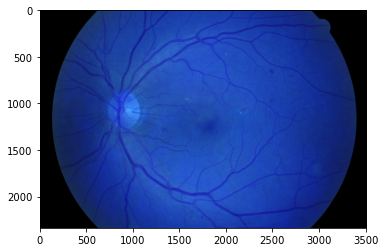

In [42]:
image = cv.imread('data/all/images/07_dr.JPG')
imshow(image, cmap='gray')


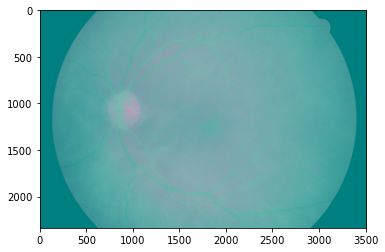

In [43]:
# convert to CIELAB color space and extract lightness
image_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
imshow(image_lab)
l, a, b = cv.split(image_lab)


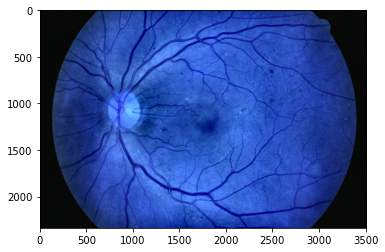

In [44]:
# apply contrast limited adaptive histogram equalization to the L channel
# https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c
clahe = cv.createCLAHE(clipLimit=3.0)
merged = cv.merge((clahe.apply(l), a, b))
merged = cv.cvtColor(merged, cv.COLOR_LAB2BGR)
# imshow(clahe.apply(l))
imshow(merged)


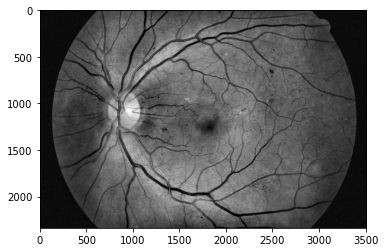

In [45]:
# convert image to BGR and extract green channel (vessels' visibility is the best)
b, g, r = cv.split(merged)

imshow(g, cmap='gray')


In [46]:
from skimage.util import img_as_bool
from skimage.morphology import binary_erosion, remove_small_objects
green = img_as_bool(g)
green_eroded = binary_erosion(green)
image_frangi = frangi(g)


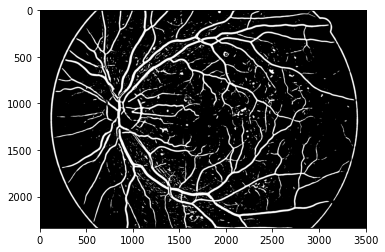

In [47]:
ret, thresh = cv.threshold(image_frangi, np.mean(
    image_frangi), 255, cv.THRESH_BINARY)
thresh = thresh.astype('uint8')
imshow(thresh, cmap='gray')


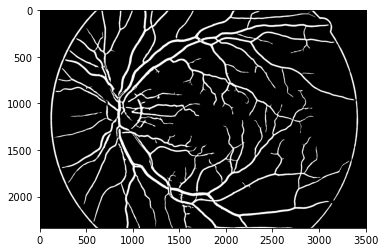

In [48]:
deblobed = thresh > 0
deblobed = remove_small_objects(deblobed, 2500, connectivity=2)
deblobed = deblobed.astype('uint8')*255
# deblobed = cv.erode(deblobed, cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2)))
imshow(deblobed, cmap='gray')


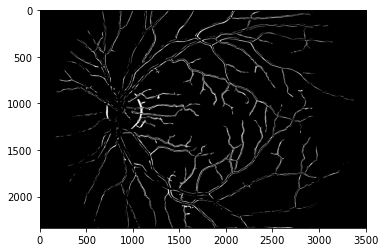

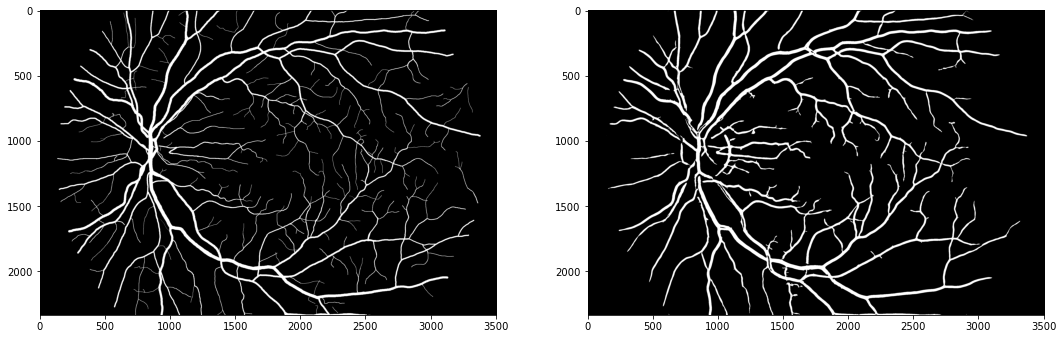

In [49]:
from matplotlib import pyplot as plt
# load the hand-made mask
mask = cv.imread('data/all/manual1/07_dr.tif', cv.IMREAD_GRAYSCALE)
cut = cv.imread('data/all/mask/07_dr_mask.tif', cv.IMREAD_GRAYSCALE)
cut = cv.bitwise_and(cut, deblobed)
# imshow(mask, cmap='gray')
diff = (cut - mask)
imshow(diff, cmap='gray')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 12)
ax1.imshow(mask, cmap='gray')
ax2.imshow(cut, cmap='gray')


TN 7278462
FP 270523
FN 127283
TP 509076
0


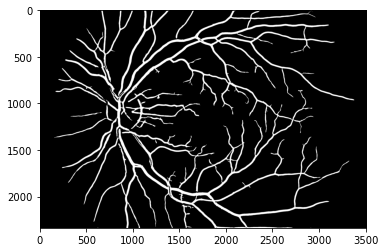

In [52]:
from sklearn.metrics import confusion_matrix
processed = cut
imshow(cut, cmap='gray')

image_size = processed.shape[0]*processed.shape[1]

mask_binary = mask.copy()
mask_binary[mask_binary < 127] = 0
mask_binary[mask_binary >= 127] = 1

processed_binary = processed.copy()
processed_binary[processed_binary < 127] = 0
processed_binary[processed_binary >= 127] = 1

#TN, FP, FN, TP = confusion_matrix(mask_binary.flatten(), processed_binary.flatten()).ravel()
TP = np.sum(processed_binary[mask_binary == 1])
FP = np.sum(processed_binary[mask_binary == 0])
FN = np.sum(mask_binary[mask_binary == 1]) - \
    np.sum(processed_binary[mask_binary == 1])
TN = image_size - np.sum(processed_binary[mask_binary == 0]) - TP - FN
image_size = mask_binary.shape[0]*mask_binary.shape[1]
print(f'TN', TN)
print(f'FP', FP)
print(f'FN', FN)
print(f'TP', TP)
#print(FN + FP + TP + TN - image_size)


In [51]:
accuracy = (TP + TN) / (TP + FP + FN + TN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f'accuracy:', accuracy)
print(f'sensitivity : ', sensitivity)
print(f'specificity: ', specificity)


accuracy: 0.9514002099361981
sensitivity :  0.7999823998717704
specificity:  0.9641643214286424
